In [1]:
%load_ext autoreload
#%autoreload 2

import numpy as np
import pandas as pd
import warnings
import riskfolio as rp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, NonlinearConstraint
from efficientfrontier import optimize

pd.options.display.float_format = '{:.2%}'.format

In [2]:
xl = pd.ExcelFile('wartosci_walorow_12_22.xlsx')
sheets = xl.sheet_names

merged = xl.parse(sheets.pop(0))
print(sheets)

for sheet in sheets:
    data = xl.parse(sheet)    
    merged = merged.merge(data, on='Date', how='left') 

xl.close()


['MSCI ACWI', 'MWITR', 'TBSP', 'EURPLN', 'EDO', 'Bloomberg Barclays Global Aggre', 'Gold spot price', 'Global aggregate euro hdg', 'EURO STOXX 50 Daily Leverage', 'Bloomberg Barclays Global Corpo']


In [3]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 455
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 456 non-null    datetime64[ns]
 1   GovBondG7            456 non-null    float64       
 2   ACWI                 421 non-null    float64       
 3   Mwig40tr             156 non-null    float64       
 4   TBSP                 192 non-null    float64       
 5   EURPLN               255 non-null    float64       
 6   EDO                  226 non-null    float64       
 7   GlobalCorporate      124 non-null    float64       
 8   Gold                 456 non-null    float64       
 9   GABHDG               62 non-null     float64       
 10  EURO_STOXX_Leverage  253 non-null    float64       
 11  Fallen_Angels        79 non-null     float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 46.3 KB


In [4]:
assets = merged.columns[1:]
price_changes = merged[assets].pct_change()
price_changes.set_index(merged['Date'], inplace=True)

In [5]:
price_changes.to_excel('oryginal_price_changes.xlsx')

In [6]:
euro_assets = ['ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels']
pln_assets = ['Mwig40tr', 'TBSP', 'EDO']

pln = merged[euro_assets].apply(lambda x: x * merged['EURPLN'])
pln_chng = pln.pct_change()
pln_chng.set_index(merged['Date'], inplace=True)
pln_chng = pd.merge(price_changes[pln_assets], pln_chng, left_index=True, right_index=True)

In [7]:
#pln_chng.to_excel('pln_price_changes2.xlsx')
pln_chng.to_csv('pln_price_changes2.csv', float_format='%.3f')

In [8]:
assets = pln_chng
assets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 1985-01-01 to 2022-12-01
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mwig40tr             155 non-null    float64
 1   TBSP                 191 non-null    float64
 2   EDO                  225 non-null    float64
 3   ACWI                 254 non-null    float64
 4   GovBondG7            254 non-null    float64
 5   GlobalCorporate      123 non-null    float64
 6   Gold                 254 non-null    float64
 7   GABHDG               61 non-null     float64
 8   EURO_STOXX_Leverage  252 non-null    float64
 9   Fallen_Angels        78 non-null     float64
dtypes: float64(10)
memory usage: 55.4 KB


In [9]:
def annullised_mean(series):
    return np.mean(series)*12

def annullised_std(series):
    return np.std(series) * np.sqrt(12)

def pstd(weights, cov_matrix):
    #variance = np.transpose(weights)@cov_matrix@weights
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)

def pmean(weightsDf, means):  
    weights = weightsDf
    return np.sum(weights * means)

def portfolioMeasures(weights,means,cov_table):
    mu = np.apply_along_axis(pmean,1,weights, means=means)
    std = np.apply_along_axis(pstd,1,weights, cov_matrix=cov_table) 
    return np.array([mu,std]).T

In [10]:
perf60 = assets.iloc[-60:].agg(['mean', np.std])
perf60.iloc[0,:] = perf60.iloc[0,:]*12
perf60.iloc[1,:] = perf60.iloc[1,:] * np.sqrt(12)
perf60

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,2.32%,0.00%,4.43%,11.67%,2.38%,4.06%,11.94%,0.80%,15.18%,8.49%
std,21.69%,5.83%,0.58%,18.02%,8.12%,9.34%,12.30%,8.55%,40.21%,12.23%


In [11]:
perf60 = assets.loc['01-11-2017':'01-12-2021'].agg(['mean', np.std])
perf60.iloc[0,:] = perf60.iloc[0,:]*12
perf60.iloc[1,:] = perf60.iloc[1,:] * np.sqrt(12)
perf60

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,3.25%,4.85%,2.89%,11.50%,2.83%,4.25%,9.31%,6.88%,14.45%,8.28%
std,20.76%,1.76%,0.27%,16.40%,7.83%,9.16%,11.93%,6.85%,37.74%,12.19%


In [12]:
corr60 = assets.iloc[-60:].corr(method='pearson')
#corr60 = assets.iloc[-60:].cov()
corr60.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
Mwig40tr,100.00%,4.29%,1.81%,-30.80%,-41.21%,-38.10%,-22.17%,-37.96%,-17.20%,-34.14%
TBSP,4.29%,100.00%,-11.19%,-5.04%,-4.58%,-2.29%,6.80%,8.64%,-11.49%,4.13%
EDO,1.81%,-11.19%,100.00%,-5.86%,-26.96%,-17.48%,-13.98%,-14.08%,7.61%,-9.33%
ACWI,-30.80%,-5.04%,-5.86%,100.00%,37.32%,70.60%,9.68%,57.11%,83.57%,83.90%
GovBondG7,-41.21%,-4.58%,-26.96%,37.32%,100.00%,85.02%,47.04%,59.25%,4.40%,62.18%
GlobalCorporate,-38.10%,-2.29%,-17.48%,70.60%,85.02%,100.00%,38.44%,66.15%,41.59%,91.47%
Gold,-22.17%,6.80%,-13.98%,9.68%,47.04%,38.44%,100.00%,39.38%,-17.38%,30.07%
GABHDG,-37.96%,8.64%,-14.08%,57.11%,59.25%,66.15%,39.38%,100.00%,44.68%,61.17%
EURO_STOXX_Leverage,-17.20%,-11.49%,7.61%,83.57%,4.40%,41.59%,-17.38%,44.68%,100.00%,58.81%
Fallen_Angels,-34.14%,4.13%,-9.33%,83.90%,62.18%,91.47%,30.07%,61.17%,58.81%,100.00%


In [13]:
perf120 = assets.iloc[-120:].agg(['mean', np.std])
perf120.iloc[0,:] = perf120.iloc[0,:]*12
perf120.iloc[1,:] = perf120.iloc[1,:] * np.sqrt(12)
perf120

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,9.26%,1.90%,3.26%,12.81%,2.56%,4.72%,5.43%,0.69%,17.54%,7.54%
std,17.89%,4.73%,0.59%,15.21%,8.94%,9.33%,15.28%,8.48%,35.24%,11.28%


In [14]:
corr120 = assets.iloc[-120:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr120.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
Mwig40tr,100.00%,4.09%,-2.53%,-26.05%,-35.52%,-34.43%,-29.45%,-37.71%,-13.60%,-29.83%
TBSP,4.09%,100.00%,-12.85%,-9.22%,-15.34%,-12.34%,-7.32%,8.52%,-9.96%,-0.25%
EDO,-2.53%,-12.85%,100.00%,-2.09%,-14.90%,-10.80%,-5.09%,-13.41%,5.30%,-4.69%
ACWI,-26.05%,-9.22%,-2.09%,100.00%,40.48%,69.42%,16.35%,57.15%,81.87%,84.21%
GovBondG7,-35.52%,-15.34%,-14.90%,40.48%,100.00%,89.02%,55.72%,59.24%,8.83%,64.17%
GlobalCorporate,-34.43%,-12.34%,-10.80%,69.42%,89.02%,100.00%,47.14%,66.16%,40.62%,91.53%
Gold,-29.45%,-7.32%,-5.09%,16.35%,55.72%,47.14%,100.00%,39.48%,-4.66%,32.20%
GABHDG,-37.71%,8.52%,-13.41%,57.15%,59.24%,66.16%,39.48%,100.00%,44.77%,61.19%
EURO_STOXX_Leverage,-13.60%,-9.96%,5.30%,81.87%,8.83%,40.62%,-4.66%,44.77%,100.00%,59.90%
Fallen_Angels,-29.83%,-0.25%,-4.69%,84.21%,64.17%,91.53%,32.20%,61.19%,59.90%,100.00%


In [15]:
perf180 = assets.iloc[-150:].agg(['mean', np.std])
perf180.iloc[0,:] = perf180.iloc[0,:]*12
perf180.iloc[1,:] = perf180.iloc[1,:] * np.sqrt(12)
perf180

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,8.38%,3.07%,3.53%,12.37%,2.72%,4.44%,6.56%,0.69%,16.38%,7.54%
std,17.63%,4.40%,0.55%,15.03%,9.98%,9.25%,16.38%,8.48%,35.90%,11.28%


In [16]:
corr180 = assets.iloc[-150:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr180.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,EDO,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
Mwig40tr,100.00%,6.49%,-2.44%,-29.47%,-41.78%,-34.82%,-27.75%,-37.71%,-14.29%,-29.83%
TBSP,6.49%,100.00%,-5.99%,-13.44%,-16.44%,-13.38%,-8.90%,8.52%,-10.80%,-0.25%
EDO,-2.44%,-5.99%,100.00%,-2.38%,-12.09%,-11.51%,-3.81%,-13.41%,4.69%,-4.69%
ACWI,-29.47%,-13.44%,-2.38%,100.00%,35.53%,69.42%,17.75%,57.15%,79.19%,84.21%
GovBondG7,-41.78%,-16.44%,-12.09%,35.53%,100.00%,88.76%,52.15%,59.24%,-3.26%,64.17%
GlobalCorporate,-34.82%,-13.38%,-11.51%,69.42%,88.76%,100.00%,47.66%,66.16%,40.27%,91.53%
Gold,-27.75%,-8.90%,-3.81%,17.75%,52.15%,47.66%,100.00%,39.48%,-9.23%,32.20%
GABHDG,-37.71%,8.52%,-13.41%,57.15%,59.24%,66.16%,39.48%,100.00%,44.77%,61.19%
EURO_STOXX_Leverage,-14.29%,-10.80%,4.69%,79.19%,-3.26%,40.27%,-9.23%,44.77%,100.00%,59.90%
Fallen_Angels,-29.83%,-0.25%,-4.69%,84.21%,64.17%,91.53%,32.20%,61.19%,59.90%,100.00%


<AxesSubplot:xlabel='Date'>

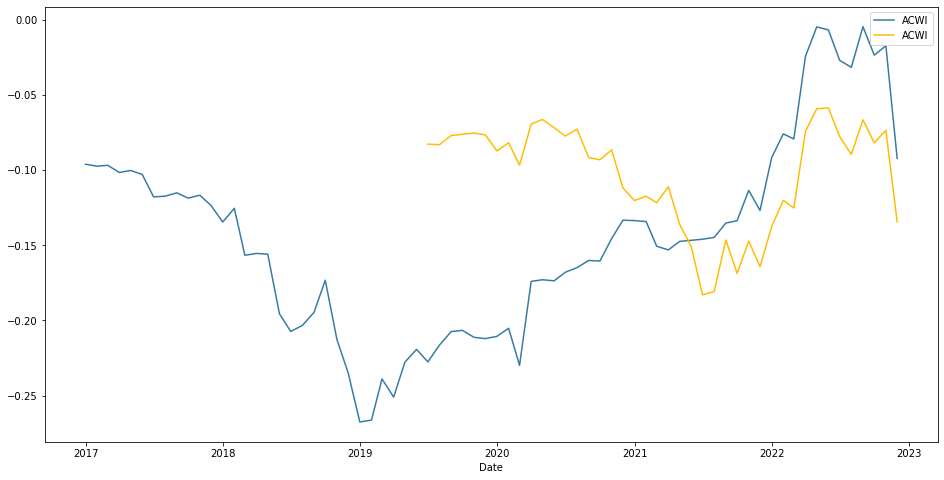

In [17]:
moving_corr = assets[['ACWI']].rolling(120).corr(assets['TBSP'])
moving_corr60 = assets[['ACWI']].rolling(150).corr(assets['TBSP'])
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=moving_corr, ax=ax, palette='mako')
sns.lineplot(data=moving_corr60, ax=ax, palette='Wistia_r')

In [18]:
portfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'EURO_STOXX_Leverage', 'EDO']]
means = pd.DataFrame(portfolio_assets.mean()*12)
cov = pd.DataFrame(portfolio_assets.cov())
portfolio_assets['01-01-2003':'01-01-2004']
portfolio_assets['01-12-2017':'01-12-2021']

,Mwig40tr,TBSP,ACWI,Gold,EURO_STOXX_Leverage,EDO
Date,,,,,,
2017-02-01,10.14%,-0.13%,2.40%,3.07%,3.85%,0.10%
2017-03-01,4.24%,0.39%,0.03%,-2.09%,11.27%,0.10%
2017-04-01,-1.99%,1.33%,-2.35%,-2.23%,2.14%,0.10%
2017-05-01,2.48%,0.32%,-0.48%,-2.73%,2.61%,0.10%
2017-06-01,-0.44%,0.96%,-2.20%,-4.52%,-6.82%,0.10%
2017-07-01,2.74%,0.15%,1.26%,0.48%,1.74%,0.12%
2017-08-01,1.03%,0.10%,0.14%,3.19%,-0.98%,0.12%
2017-09-01,-0.05%,0.52%,1.97%,-2.18%,10.43%,0.12%
2017-10-01,1.64%,-0.02%,5.16%,1.96%,6.21%,0.17%


In [19]:
#assets ['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels', 'EDO']
#['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'GovBondG7', 'EDO]

porfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'GovBondG7', 'EDO']]
port = rp.Portfolio(porfolio_assets[-123:])



means = pd.DataFrame(portfolio_assets['01-01-2004':'01-12-2022'].mean()*12)
cov = pd.DataFrame(portfolio_assets['01-01-2004':'01-12-2022'].cov())

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

points = 15 # Number of points of the frontier
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm =  'MV' #'MV' vs 'MDD' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.00 # Risk free rate

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head(50))




,Mwig40tr,TBSP,ACWI,Gold,GovBondG7,EDO
0,0.45%,3.08%,0.00%,0.00%,2.02%,94.46%
1,6.47%,0.00%,8.96%,1.89%,0.00%,82.69%
2,10.99%,0.00%,15.34%,2.92%,0.00%,70.75%
3,15.40%,0.00%,21.57%,3.93%,0.00%,59.10%
4,19.77%,0.00%,27.75%,4.93%,0.00%,47.54%
5,24.13%,0.00%,33.91%,5.93%,0.00%,36.03%
6,28.48%,0.00%,40.05%,6.93%,0.00%,24.53%
7,32.83%,0.00%,46.19%,7.93%,0.00%,13.05%
8,37.17%,0.00%,52.33%,8.92%,0.00%,1.58%
9,38.74%,0.00%,60.73%,0.53%,0.00%,0.00%


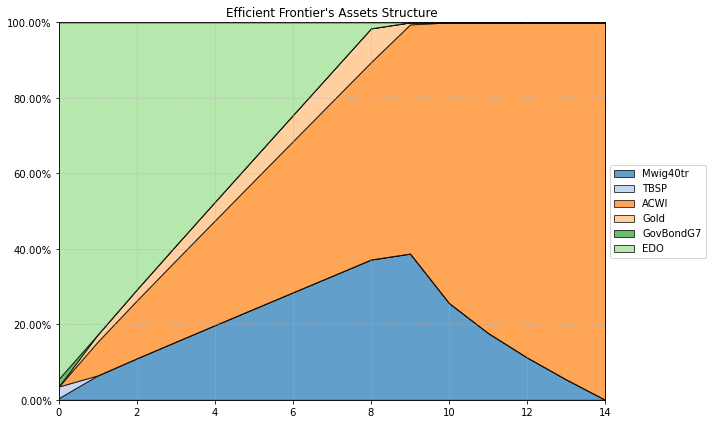

In [20]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [21]:
porfolio_assets[-150:].cov().to_numpy()
frontier.values.T
porfolio_assets[-150:].mean().values.T*12

array([0.0838378 , 0.03067022, 0.12365509, 0.06559336, 0.02720226,
       0.03527836])

In [22]:
measures = portfolioMeasures(frontier.values.T,porfolio_assets[-150:].mean().values.T, porfolio_assets[-150:].cov().to_numpy())
measures[:,0] = measures[:,0]*12
measures[:,1] = measures[:,1]*np.sqrt(12)

measures

array([[0.03519068, 0.00528686],
       [0.0469084 , 0.01548693],
       [0.05505872, 0.02569391],
       [0.06301184, 0.03588331],
       [0.07090147, 0.04606665],
       [0.07876275, 0.05624732],
       [0.08660875, 0.06642652],
       [0.09444595, 0.07660495],
       [0.10227776, 0.08678306],
       [0.10792318, 0.09652981],
       [0.11345244, 0.10751325],
       [0.11660844, 0.11831416],
       [0.1191954 , 0.12902325],
       [0.12150745, 0.13967592],
       [0.12365509, 0.15028918]])

In [23]:
porfolio = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'GovBondG7', 'EDO']].iloc[-150:]
porfolio.cov()


,Mwig40tr,TBSP,ACWI,Gold,GovBondG7,EDO
Mwig40tr,0.26%,0.00%,-0.07%,-0.07%,-0.06%,-0.00%
TBSP,0.00%,0.02%,-0.01%,-0.01%,-0.01%,-0.00%
ACWI,-0.07%,-0.01%,0.19%,0.04%,0.04%,-0.00%
Gold,-0.07%,-0.01%,0.04%,0.22%,0.07%,-0.00%
GovBondG7,-0.06%,-0.01%,0.04%,0.07%,0.08%,-0.00%
EDO,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%,0.00%


In [31]:

assets = ['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'GovBondG7', 'EDO']
expectedMean = 0.12
means = porfolio.mean()
cov_table = porfolio.cov()
result = optimize(expectedMean, means,cov_table)

pd.DataFrame([result.T],columns=assets)


,Mwig40tr,TBSP,ACWI,Gold,GovBondG7,EDO
0,9.18%,0.00%,90.82%,0.00%,0.00%,0.00%


In [41]:
mu_min = means.min()
mu_max = means.max()

portfolio_means = np.linspace(mu_min, mu_max, 15)
portfolio_means

weights = np.zeros((1,6))
for mean in portfolio_means:
    weight = optimize(mean,means,cov_table)
    weights = np.append(weights, [weight], axis=0)

pd.DataFrame(weights, columns=assets)


,Mwig40tr,TBSP,ACWI,Gold,GovBondG7,EDO
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
1,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
2,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
3,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
4,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
5,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
6,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
7,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
8,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
9,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
